### Alternate contacts Analysis 

This notebook looks at possible alternative contacts that could be formed given a target protein (suggested by our dataset).  

We chose the beta-lactamase TEM1 as the target protein due to the available experimental data in which fitness values for almost all single point mutations were determined. 

We found all possible single point mutations suggested by our approach and compare these values to two alternative selection methods. 

In [1]:
import ast
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from tools_proj.msa_indexing import parse_fasta, clean_up_sequence, parse_contact_output, indexing_pdb_to_msa
from tools_proj.alternate_contacts import find_equivalent_contacts, find_possible_single_point_mutations
from tools_proj.utils import per_residue_distance_to_site

# Constants. 

TARGET_PROTEIN = "1M40_TEM-1"
TEM1_ACTIVE_SITE_DEF = r"resid 45 141 and not backbone and not name H"

TEM1_PDB_FILE = r"../protein_prep/5_tleap/1BTL_tem1_apo_postleap.pdb"
MSA_SEQUENCES_FILE = r"../src/tests/data/bettaLac.ali"
TEM1_FITNESS_DF = r"tem1_fitness_data/per_mutation_fitness.csv"
TEM1_RES_RES_SCORES_FILE = r"../contact_analysis/static_contacts_processing/shared_network/network_tem1_pdb.csv"
TEM1_RES_RES_MD_SCORES_FILES = {
    "0% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_0.csv",
    "10% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_10.csv",
    "50% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_50.csv",
    "90% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_90.csv",
    "95% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_95.csv",
}
AMINO_ACID_GROUPS = {
    "Polar": ["S", "T", "C", "Y", "N", "Q"],
    "Non-Polar": ["A", "V", "L", "I", "P", "M", "F", "W"],
    "Acidic": ["D", "E"],
    "Basic": ["K", "R", "H"],
    "Special": ["C", "P", "G"],
    "Aromatic": ["F", "Y", "W"],
    "Sulfur-Containing": ["C", "M"]
}

/home/roryc760/miniconda3/envs/tools_proj/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


### Part 1: Prepare the datasets

prep the experimental fitness data we will compare to

In [2]:
tem1_fitness_df = pd.read_csv(TEM1_FITNESS_DF)
display(tem1_fitness_df.shape)
tem1_fitness_df.head(3)

(4997, 4)

,Residue Number,WT AA,Mutant AA,Fitness
0,1,H,A,1.294305
1,1,H,C,0.564646
2,1,H,D,1.099183


Prep the contact dataset to study TEM1 

In [3]:
all_msa_seqs = parse_fasta(MSA_SEQUENCES_FILE)

# get tem1 sequence in protein format. 
target_prot_seq = []
for letter in all_msa_seqs[TARGET_PROTEIN]:
    if letter == "-" or letter == "*":
        continue
    target_prot_seq.append(letter)

# distance of each TEM1 residue to the active site. 
min_dists = per_residue_distance_to_site(
    pdb_file=TEM1_PDB_FILE,
    site_defintion=TEM1_ACTIVE_SITE_DEF,
    first_residue=1,
    last_residue=263,
    side_chain_only=False,
    out_file=None)

# dataframes of contacts with msa numbering for each protein. 
all_msa_contacs_dfs = {}
for protein in all_msa_seqs.keys():
    contacts_path = fr"../network_analysis/crystal_structure_contacts/raw_contacts/{protein}_contacts.txt"
    seq, short_seq = clean_up_sequence(all_msa_seqs, protein)
    pdb_df_crystal = parse_contact_output(contacts_path, contact_type="crystal")
    msa_df_crystal = indexing_pdb_to_msa(seq, pdb_df_crystal)

    all_msa_contacs_dfs[protein] = msa_df_crystal

/home/roryc760/projects/tools-project/src/tools_proj/msa_indexing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input["Missing_res_msa"] = np.nan
/home/roryc760/projects/tools-project/src/tools_proj/msa_indexing.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input["Missing_res_msa"] = df_input["Missing_res_msa"].astype(pd.Int64Dtype())
/home/roryc760/projects/tools-project/src/tools_proj/msa_indexing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [4]:
tmp_dict = pd.read_csv(TEM1_RES_RES_SCORES_FILE).T[0].to_dict()

tem1_res_res_data = {}
for old_key, score in tmp_dict.items():
    new_key = ast.literal_eval(old_key)
    tem1_res_res_data[new_key] = score
    
tem1_res_res_data = sorted(tem1_res_res_data.items(), key=lambda x:x[1], reverse=True)
print(len(tem1_res_res_data), tem1_res_res_data)

280 [((12, 16), 1.0), ((45, 48), 1.0), ((47, 51), 1.0), ((48, 52), 1.0), ((49, 53), 1.0), ((50, 54), 1.0), ((51, 55), 1.0), ((52, 56), 1.0), ((92, 97), 1.0), ((93, 97), 1.0), ((94, 98), 1.0), ((95, 99), 1.0), ((96, 100), 1.0), ((97, 101), 1.0), ((98, 102), 1.0), ((100, 106), 1.0), ((106, 110), 1.0), ((107, 111), 1.0), ((108, 112), 1.0), ((109, 113), 1.0), ((110, 114), 1.0), ((111, 115), 1.0), ((112, 116), 1.0), ((113, 117), 1.0), ((123, 127), 1.0), ((124, 128), 1.0), ((157, 161), 1.0), ((158, 162), 1.0), ((159, 163), 1.0), ((160, 164), 1.0), ((161, 165), 1.0), ((162, 166), 1.0), ((163, 167), 1.0), ((175, 179), 1.0), ((176, 180), 1.0), ((177, 181), 1.0), ((178, 182), 1.0), ((179, 183), 1.0), ((252, 256), 1.0), ((253, 257), 1.0), ((254, 258), 1.0), ((255, 259), 1.0), ((256, 260), 1.0), ((257, 261), 1.0), ((258, 262), 1.0), ((36, 39), 0.9852941176470588), ((53, 57), 0.9852941176470588), ((54, 58), 0.9852941176470588), ((99, 103), 0.9852941176470588), ((55, 59), 0.9850746268656716), ((180,

Now we can make a plot of contact conservation vs dist from active site 

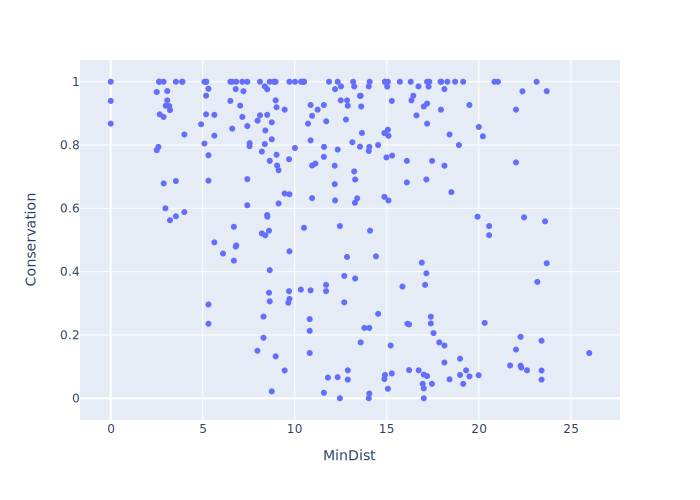

In [5]:
conservation_vs_dist = []
for res_pair, score in tem1_res_res_data:
    res1, res2 = res_pair
    min_res_res_dist = min(min_dists[res1],  min_dists[res2])

    conservation_vs_dist.append({"Res1": res1, "Res2": res2, "MinDist": min_res_res_dist, "Conservation": score})
conservation_vs_dist_df = pd.DataFrame(conservation_vs_dist)

fig = px.scatter(conservation_vs_dist_df, x="MinDist", y="Conservation", hover_data=["Res1", "Res2"])
fig.show("svg") # remove "svg" to make the figure interactive. 

### Part 2: Generate Datasets for the comparison to the fitness data. 

We will try three different scenarios:
1. All possible mutations are allowed (base case)
2. Mutations between similar residues are allowed.  
3. Mutations suggested by our altenative contacts analysis. We will further test our approach by trying:
    - Using a cutoff to control which mutations are tried based on distance from TEM1 active site. 
    - Using MD simulation data to generate new contacts to try, alongside play around with the cut-off. 

In [6]:
# Version 2 of the list above, version 1 is just the whole dataframe of fitness values
def find_target_amino_acids_group(target_residue:str) -> str:
    """
    Find the group the target amino acid belongs to. 
    """
    for amino_group, amino_acids in AMINO_ACID_GROUPS.items():
        if target_residue in amino_acids:
            return amino_group

    # should not be possible to get here... 
    raise ValueError()

similar_res_fitness_scores = []
for res_numb, target_residue in enumerate(target_prot_seq, start=1): 

    # make list of residues with simmilar 
    amino_group = find_target_amino_acids_group(target_residue)
    allowed_res = AMINO_ACID_GROUPS[amino_group]
    allowed_res = [res for res in allowed_res if res != target_residue]

    # Filter the df by the res number and then the allowed mutations.
    res_df = tem1_fitness_df[ tem1_fitness_df["Residue Number"] == res_numb ] 
    allowed_muts_df = res_df [ res_df["Mutant AA"].isin(allowed_res) ] 

    # Extract the fitness values... 
    similar_res_fitness_scores += list(allowed_muts_df["Fitness"].values)

# remove nans 
similar_res_fitness_scores = [x for x in similar_res_fitness_scores if str(x) != 'nan']

In [7]:
conservation_vs_dist_df.head(3)

,Res1,Res2,MinDist,Conservation
0,12,16,21.04,1.0
1,45,48,0.00,1.0
2,47,51,3.54,1.0


In [8]:
# create versions of the above df using different distance from active site cutoffs. 
dfs_to_eval = {}
for max_dist in ["5", "10", "15", "20", "25", "30"]:
    query_string = f"MinDist < {max_dist}"
    df = conservation_vs_dist_df.query(query_string).copy(deep=True)
    dfs_to_eval[max_dist] = df
print(f" {len(dfs_to_eval['10'])=}, {len(dfs_to_eval['15'])=}, {len(dfs_to_eval['20'])=}, {len(dfs_to_eval['25'])=}, {len(dfs_to_eval['30'])=} " )

 len(dfs_to_eval['10'])=107, len(dfs_to_eval['15'])=188, len(dfs_to_eval['20'])=254, len(dfs_to_eval['25'])=279, len(dfs_to_eval['30'])=280 


In [9]:
# Obtain all the fitness values for each selection
all_fitness_comparisons = {}
for max_dist, df in dfs_to_eval.items(): 
    fitness_comparisons = []
    for idx, row in df.iterrows():
        target_res1, target_res2 = int(row[0]), int(row[1]),
        
        contact_combinations, _ = find_equivalent_contacts(
            all_msa_contacs_dfs=all_msa_contacs_dfs, 
            target_res_pair=(target_res1, target_res2), 
            target_msa_seq=all_msa_seqs[TARGET_PROTEIN],
            no_vdws=True, 
        )

        mutations_to_try = find_possible_single_point_mutations(
            contact_combinations=contact_combinations, 
            target_res_pair=(target_res1, target_res2),
            target_prot_seq=target_prot_seq, 
        )

        if mutations_to_try:
            for mutation in mutations_to_try:
                # filter to be just that residue. 
                res_df = tem1_fitness_df[ tem1_fitness_df["Residue Number"] == mutation["res_numb"] ] 
                avg_res_fitness = res_df["Fitness"].mean()
                mutation_fitness = res_df[ res_df["Mutant AA"] == mutation["mutated_res"] ]["Fitness"].values[0]

                if np.isnan(mutation_fitness):
                    continue # if mutation not tested 

                delta_fitness = mutation_fitness - avg_res_fitness

                fitness_comparisons.append(
                    {"res_numb":  mutation["res_numb"],
                    "wt_res":  mutation["wt_res"],
                    "mutated_res":  mutation["mutated_res"],
                    "mutation_fitness": mutation_fitness, 
                    "avg_res_fitness": avg_res_fitness,
                    "delta_fitness": delta_fitness,
                    }
                )
    df_fitness_comparisons = pd.DataFrame(fitness_comparisons)
    all_fitness_comparisons[max_dist] = df_fitness_comparisons

print(all_fitness_comparisons["10"])

/tmp/ipykernel_83811/3781521890.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



     res_numb wt_res mutated_res  mutation_fitness  avg_res_fitness  \
0          51      L           A          0.340430         0.159548   
1          52      C           A          0.851460         0.258987   
2          52      C           V          1.048270         0.258987   
3          52      C           S          0.431922         0.258987   
4          52      C           G          0.622343         0.258987   
..        ...    ...         ...               ...              ...   
158       115      T           A          1.277689         1.073204   
159       115      T           K          1.301573         1.073204   
160       114      L           I          0.710216         0.269111   
161       189      D           N          0.412526         0.146150   
162       114      L           F          0.588322         0.269111   

     delta_fitness  
0         0.180882  
1         0.592473  
2         0.789284  
3         0.172936  
4         0.363356  
..             ...  


In [10]:
for max_dist, df in all_fitness_comparisons.items():
    print(f"Mean fitness for {max_dist=} : {all_fitness_comparisons[max_dist]['mutation_fitness'].mean():.2}" )
    print(f"Median fitness for {max_dist=} : {all_fitness_comparisons[max_dist]['mutation_fitness'].median():.2}" )

Mean fitness for max_dist='5' : 0.77
Median fitness for max_dist='5' : 0.88
Mean fitness for max_dist='10' : 0.77
Median fitness for max_dist='10' : 0.86
Mean fitness for max_dist='15' : 0.8
Median fitness for max_dist='15' : 0.88
Mean fitness for max_dist='20' : 0.83
Median fitness for max_dist='20' : 0.9
Mean fitness for max_dist='25' : 0.83
Median fitness for max_dist='25' : 0.9
Mean fitness for max_dist='30' : 0.83
Median fitness for max_dist='30' : 0.9


In [11]:
len(tem1_fitness_df["Fitness"]), len(similar_res_fitness_scores), len(df_fitness_comparisons["mutation_fitness"])

(4997, 1162, 365)

### Part 3. Analyse MD data in equivalent manner

Instead of using just the crystal structure as described above, use MD simulation data to obtain even more contacts/mutations to consider

In [12]:
md_dfs = {}
for cutoff, file_path in TEM1_RES_RES_MD_SCORES_FILES.items():
    
    tmp_dict = pd.read_csv(file_path).T[0].to_dict()
    tem1_res_res_md_data = {}
    for old_key, score in tmp_dict.items():
        new_key = ast.literal_eval(old_key)
        tem1_res_res_md_data[new_key] = score
        
    tem1_res_res_md_data = sorted(tem1_res_res_md_data.items(), key=lambda x:x[1], reverse=True)

    # df of conservation vs dist from active sites. 
    conservation_vs_dist_md = []
    for res_pair, score in tem1_res_res_md_data:
        res1, res2 = res_pair
        min_res_res_dist = min(min_dists[res1],  min_dists[res2])

        conservation_vs_dist_md.append({"Res1": res1, "Res2": res2, "MinDist": min_res_res_dist, "Conservation": score})
    conservation_vs_dist_md_df = pd.DataFrame(conservation_vs_dist_md)
    
    md_dfs[cutoff] = conservation_vs_dist_md_df

for cutoff, df in md_dfs.items():
    print(cutoff, len(df))

0% Cutoff 1441
10% Cutoff 912
50% Cutoff 551
90% Cutoff 178
95% Cutoff 58


In [13]:
# Obtain all the fitness values for each selection
all_md_fitness_comparisons = {}
for cutoff, df in md_dfs.items(): 
    fitness_comparisons = []
    for idx, row in df.iterrows():
        target_res1, target_res2 = int(row[0]), int(row[1]),
        
        contact_combinations, _ = find_equivalent_contacts(
            all_msa_contacs_dfs=all_msa_contacs_dfs, 
            target_res_pair=(target_res1, target_res2), 
            target_msa_seq=all_msa_seqs[TARGET_PROTEIN],
            no_vdws=True, 
        )

        mutations_to_try = find_possible_single_point_mutations(
            contact_combinations=contact_combinations, 
            target_res_pair=(target_res1, target_res2),
            target_prot_seq=target_prot_seq, 
        )

        if mutations_to_try:
            for mutation in mutations_to_try:
                # filter df to be just that residue. 
                res_df = tem1_fitness_df[ tem1_fitness_df["Residue Number"] == mutation["res_numb"] ] 
                avg_res_fitness = res_df["Fitness"].mean()
                mutation_fitness = res_df[ res_df["Mutant AA"] == mutation["mutated_res"] ]["Fitness"].values[0]

                if np.isnan(mutation_fitness):
                    continue # if mutation not tested 

                delta_fitness = mutation_fitness - avg_res_fitness

                fitness_comparisons.append(
                    {"res_numb":  mutation["res_numb"],
                    "wt_res":  mutation["wt_res"],
                    "mutated_res":  mutation["mutated_res"],
                    "mutation_fitness": mutation_fitness, 
                    "avg_res_fitness": avg_res_fitness,
                    "delta_fitness": delta_fitness,
                    }
                )
    df_fitness_comparisons = pd.DataFrame(fitness_comparisons)
    all_md_fitness_comparisons[cutoff] = df_fitness_comparisons

print(all_md_fitness_comparisons.keys())

/tmp/ipykernel_83811/2462803933.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



dict_keys(['0% Cutoff', '10% Cutoff', '50% Cutoff', '90% Cutoff', '95% Cutoff'])


### Part 4: Make some figures 

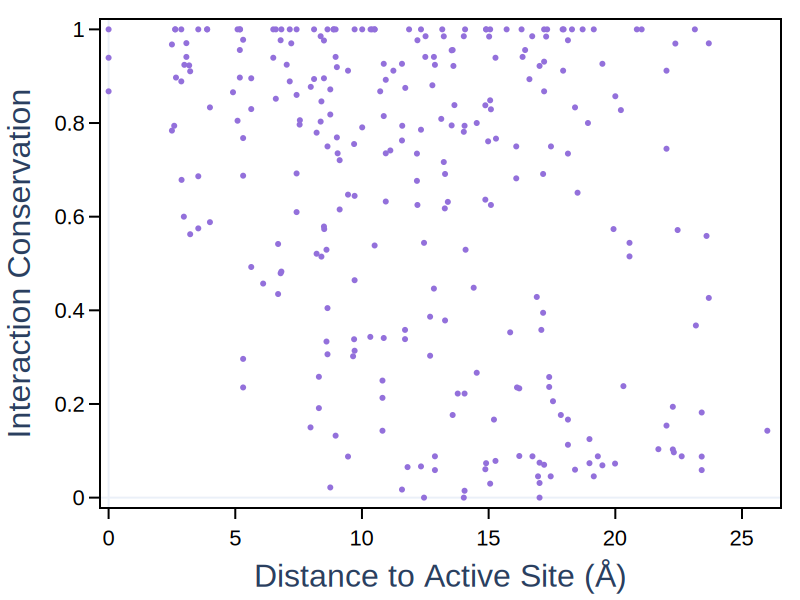

In [14]:
fig = px.scatter(conservation_vs_dist_df, x="MinDist", y="Conservation", hover_data=["Res1", "Res2"], 
                 color_discrete_sequence=["mediumpurple"], )

fig.update_layout(
    template="plotly_white",
    yaxis= dict(title="Interaction Conservation", titlefont=dict(size=32)),
    xaxis= dict(title="Distance to Active Site (Å)", titlefont=dict(size=32)),
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    font_family="Arial",
    width=800,
    height=600,
    xaxis_range=[-0.3, 26.5],
    yaxis_range=[-0.02, 1.02]
)

fig.update_xaxes(showgrid=False, showline=True, linewidth=2, linecolor='black', mirror=True, 
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=22))
fig.update_yaxes(showgrid=False, showline=True, linewidth=2, linecolor='black', mirror=True,
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=22))

fig.show("svg") # remove "svg" to make the figure interactive. 
pio.write_image(fig, r"comparison_results/conserv_vs_dist.png", scale=6)

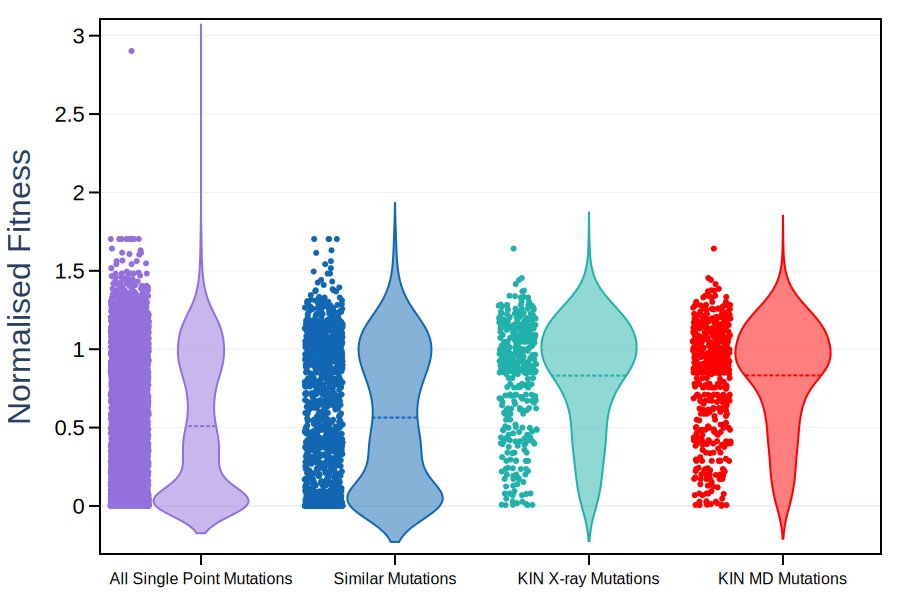

In [15]:
fig = go.Figure()

# all fitness results. 
fig.add_trace(
    go.Violin(
              y=tem1_fitness_df["Fitness"],
              line_color="mediumpurple",
              legendgroup="All Single Point Mutations", name="All Single Point Mutations",
              ),
)

fig.add_trace(
    go.Violin(
              y=similar_res_fitness_scores,
              line_color="#1167b1",
              legendgroup="Similar Mutations", name="Similar Mutations",
              ),
)

# fitness comparisons
fig.add_trace(
    go.Violin(
              y=all_fitness_comparisons["30"]["mutation_fitness"],
              line_color="lightseagreen",
              legendgroup="KIN X-ray Mutations", name="KIN X-ray Mutations",
              ),
)

# dynamics data
fig.add_trace(
    go.Violin(
              y=all_md_fitness_comparisons["10% Cutoff"]["mutation_fitness"],
              line_color="red",
              legendgroup="KIN MD Mutations", name="KIN MD Mutations",
              ),
)

#update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  points="all", # show all points
                  jitter=0.40,  # add some jitter on points for better visibility
)

fig.update_layout(
    template="plotly_white",
    yaxis= dict(title="Normalised Fitness", titlefont=dict(size=32)),
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    font_family="Arial",
    width=900,
    height=600,
    yaxis_range=[-0.3,3.1]

)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, 
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=16))
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True,
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=22))
fig.show("svg") # remove "svg" to make the figure interactive. 

pio.write_image(fig, r"comparison_results/Violin_MainText.png", scale=6)

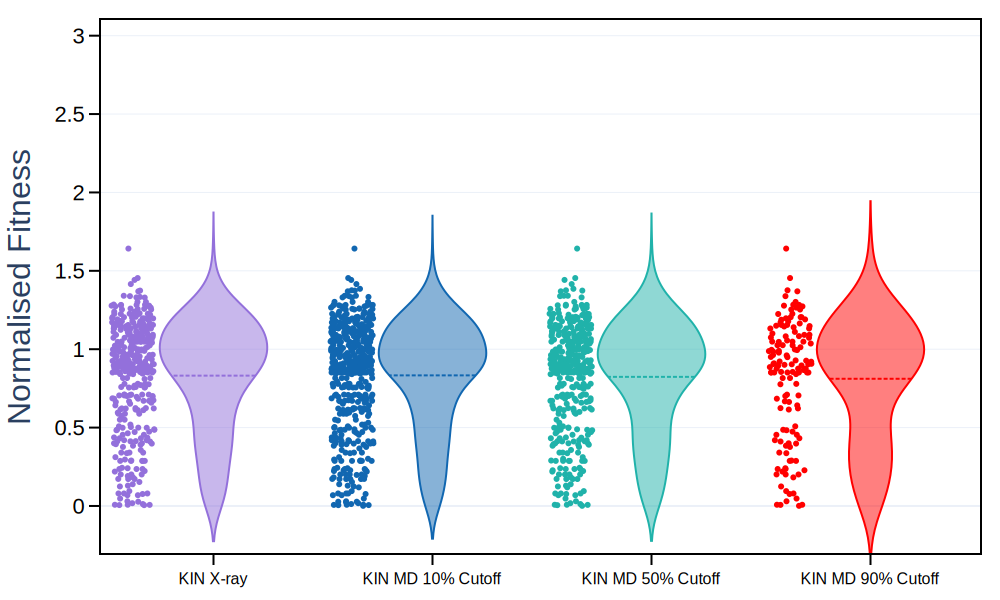

In [16]:
# SI Violin plot of different md cutoffs and X-ray cutoffs.. 
fig = go.Figure()

# all fitness results. 
fig.add_trace(
    go.Violin(
              y=all_fitness_comparisons["30"]["mutation_fitness"],
              line_color="mediumpurple",
              legendgroup="KIN X-ray", name="KIN X-ray",
              ),
)

fig.add_trace(
    go.Violin(
              y=all_md_fitness_comparisons["10% Cutoff"]["mutation_fitness"],
              line_color="#1167b1",
              legendgroup=r"KIN MD 10% Cutoff", name=r"KIN MD 10% Cutoff",
              ),
)

# fitness comparisons. 
fig.add_trace(
    go.Violin(
              y=all_md_fitness_comparisons["50% Cutoff"]["mutation_fitness"],
              line_color="lightseagreen",
              legendgroup=r"KIN MD 50% Cutoff", name=r"KIN MD 50% Cutoff",
              ),
)

# dynamics data 
fig.add_trace(
    go.Violin(
              y=all_md_fitness_comparisons["90% Cutoff"]["mutation_fitness"],
              line_color="red",
              legendgroup=r"KIN MD 90% Cutoff", name=r"KIN MD 90% Cutoff",
              ),
)

#update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  points="all", # show all points
                  jitter=0.40,  # add some jitter on points for better visibility
)

fig.update_layout(
    template="plotly_white",
    yaxis= dict(title="Normalised Fitness", titlefont=dict(size=32)),
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    font_family="Arial",
    width=1000,
    height=600,
    yaxis_range=[-0.3,3.1]

)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, 
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=16))
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True,
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=22))
fig.show("svg") # remove "svg" to make the figure interactive. 

pio.write_image(fig, r"comparison_results/Violin_SI_MD_vs_Xray.png", scale=6)

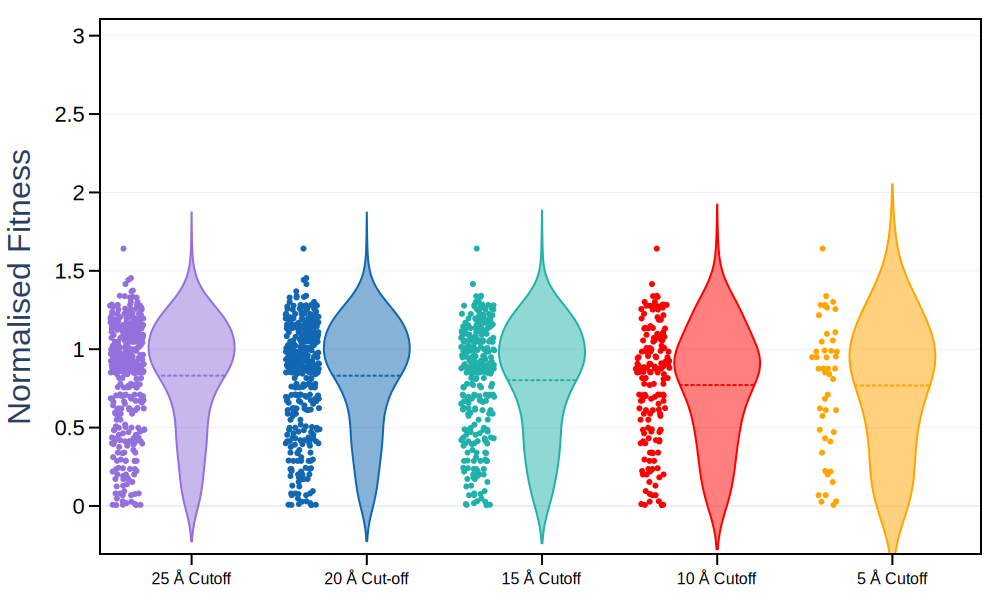

In [17]:
# SI Violin plot of different X-ray distance cutoffs. 
fig = go.Figure()


fig.add_trace(
    go.Violin(
              y=all_fitness_comparisons["25"]["mutation_fitness"],
              line_color="mediumpurple",
              legendgroup=r"25 Å Cutoff", name=r"25 Å Cutoff",
              ),
)


fig.add_trace(
    go.Violin(
              y=all_fitness_comparisons["20"]["mutation_fitness"],
              line_color="#1167b1",
              legendgroup=r"20 Å Cut-off", name=r"20 Å Cut-off",
              ),
)


fig.add_trace(
    go.Violin(
              y=all_fitness_comparisons["15"]["mutation_fitness"],
              line_color="lightseagreen",
              legendgroup=r"15 Å Cutoff", name=r"15 Å Cutoff",
              ),
)


fig.add_trace(
    go.Violin(
              y=all_fitness_comparisons["10"]["mutation_fitness"],
              line_color="red",
              legendgroup=r"10 Å Cutoff", name=r"10 Å Cutoff",
              ),
)


fig.add_trace(
    go.Violin(
              y=all_fitness_comparisons["5"]["mutation_fitness"],
              line_color="orange",
              legendgroup=r"5 Å Cutoff", name=r"5 Å Cutoff",
              ),
)

#update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  points="all", # show all points
                  jitter=0.40,  # add some jitter on points for better visibility
)

fig.update_layout(
    template="plotly_white",
    yaxis= dict(title="Normalised Fitness", titlefont=dict(size=32)),
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    font_family="Arial",
    width=1000,
    height=600,
    yaxis_range=[-0.3,3.1]

)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, 
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=16))
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True,
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=22))
fig.show("svg") # remove "svg" to make the figure interactive. 

pio.write_image(fig, r"comparison_results/Violin_SI_Xray_Dcut.png", scale=6)

#### Extra

As shown in the manuscript, you can look at a specific interacting pair and see which types of contact is formed between this pair and in what structures they are present in. 
An example of using the funtion built to do this is included below.

In [18]:
contact_combinations, contact_examples = find_equivalent_contacts(
    all_msa_contacs_dfs=all_msa_contacs_dfs, 
    target_res_pair=(165, 233), 
    target_msa_seq=all_msa_seqs[TARGET_PROTEIN],
    no_vdws=True, 
)

In [19]:
# Counts of each type of interaction throughout the dataset. 
contact_combinations

{'LEU ILE hydrophobic sc-sc': 10,
 'LEU VAL hydrophobic sc-sc': 9,
 'VAL ALA hydrophobic sc-sc': 3,
 'VAL VAL hydrophobic sc-sc': 3,
 'ALA LEU hydrophobic sc-sc': 1}

In [20]:
# PDB ids and the associated residue numbers of where these contacts can be found
contact_examples 

{'LEU ILE hydrophobic sc-sc': [('1HZO_K1', '163', '231'),
  ('1M40_TEM-1', '165', '233'),
  ('1N9B_SHV-3', '165', '233'),
  ('3P98_TEM-72', '165', '233'),
  ('3ZNY_CTX-M-96', '162', '230'),
  ('5NPO_TEM-135', '165', '233'),
  ('6J25_CTX-M-64', '163', '231'),
  ('6NIQ_RPA-1', '165', '233'),
  ('7BDR_CTX-M-15', '163', '231'),
  ('7QLP_TEM-171', '165', '233')],
 'LEU VAL hydrophobic sc-sc': [('1YLW_CTX-M-16', '165', '233'),
  ('2P74_CTX-M-9', '162', '230'),
  ('2ZQ7_CTX-M-44', '163', '231'),
  ('3BYD_OXY-1-1', '163', '231'),
  ('3W4Q_PenA-1', '159', '227'),
  ('4UA6_CTX-M-14', '164', '232'),
  ('5A92_CTX-M-97', '162', '230'),
  ('6BN3_CTX-M-151', '168', '236'),
  ('6BU3_CTX-M-27', '164', '232')],
 'VAL ALA hydrophobic sc-sc': [('3TSG_GES-14', '167', '234'),
  ('3V3R_GES-11', '167', '234'),
  ('4QU3_GES-2', '167', '234')],
 'VAL VAL hydrophobic sc-sc': [('3W4P_BPS-1d', '166', '234'),
  ('4MXG_BEL-1', '163', '231'),
  ('6AFM_BPS-3', '164', '232')],
 'ALA LEU hydrophobic sc-sc': [('5HW3_BVA-